In [1]:
from os.path import join
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import torch
import transformers as ppb

import h5py
from pandas import HDFStore
import matplotlib.pyplot as plt
import seaborn as sns

from molecule_gym.config import DATA_DIR, RESULTS_DIR

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Importing the raw dataset

Loading the raw dataset into a dataframe.

In [2]:
h5file = HDFStore(join(DATA_DIR, 'chemberta2_blood_brain_barrier_permeability.h5'), mode='r')

In [3]:
h5file.keys()

['/bbbp_raw']

In [4]:
data = h5file.get('/bbbp_raw')

In [5]:
h5file.close()

In [6]:
data.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [7]:
labels = data['p_np']
labels.value_counts()

1    1567
0     483
Name: p_np, dtype: int64

## Load pre-saved features from ChemBERTa-2

In [8]:
f = h5py.File(join(DATA_DIR, 'chemberta2_blood_brain_barrier_permeability.h5'), 'r')

In [9]:
f.keys()

<KeysViewHDF5 ['bbbp_raw', 'chemberta_2_features']>

In [10]:
features = f.get('chemberta_2_features')

In [11]:
features.shape

(2050, 7924)

In [12]:
# Distribution description of a feature sample
features_describe = pd.DataFrame(features[0,:])
features_describe.describe()

,0
count,7924.000000
mean,-6.741820
std,1.530230
min,-10.536302
25%,-7.563511
50%,-6.983957
75%,-6.325683
max,7.956779


## Feature reduction with PCA Analysis

In [13]:
from sklearn.decomposition import PCA
pca = PCA()

In [14]:
features_transformed = pca.fit_transform(features)

In [15]:
exp_var_pca = pca.explained_variance_ratio_[:20]
exp_var_pca

array([0.5938465 , 0.10870522, 0.07596859, 0.03343878, 0.02153103,
       0.01561497, 0.01211777, 0.01090148, 0.00931212, 0.00752243,
       0.00695139, 0.00620874, 0.00573067, 0.00467514, 0.00443109,
       0.00391127, 0.00385056, 0.00366863, 0.00342663, 0.00282674],
      dtype=float32)

In [16]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
cum_sum_eigenvalues

array([0.5938465 , 0.7025517 , 0.7785203 , 0.8119591 , 0.83349013,
       0.8491051 , 0.86122286, 0.8721243 , 0.8814364 , 0.8889588 ,
       0.8959102 , 0.9021189 , 0.9078496 , 0.91252476, 0.9169558 ,
       0.9208671 , 0.92471766, 0.9283863 , 0.9318129 , 0.93463963],
      dtype=float32)

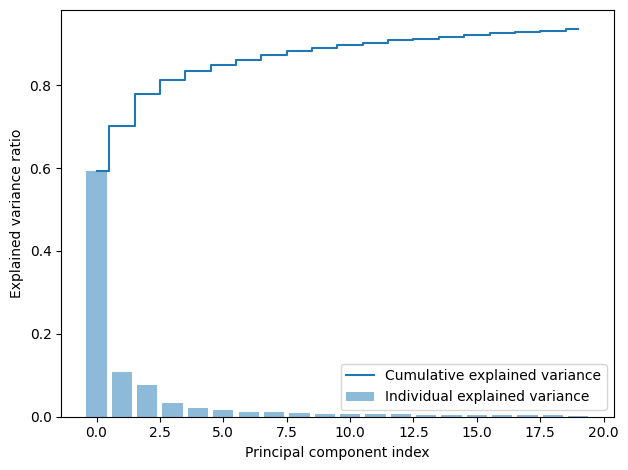

In [17]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [18]:
features_reduced = features_transformed[:,:20]

In [19]:
features_reduced.shape

(2050, 20)

## Oversampling the smallest class

In [20]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(features_reduced, labels)

In [21]:
print(X_res.shape, y_res.shape)

(3134, 20) (3134,)


In [22]:
train_features, test_features, train_labels, test_labels = train_test_split(X_res, y_res, test_size=0.3)

In [23]:
print(f"Training target statistics: {Counter(train_labels)}")
print(f"Testing target statistics: {Counter(test_labels)}")

Training target statistics: Counter({0: 1102, 1: 1091})
Testing target statistics: Counter({1: 476, 0: 465})


In [24]:
lr_clf = SVC()
lr_clf.fit(train_features, train_labels)

SVC()

In [25]:
lr_clf.score(test_features, test_labels)

0.8459086078639745

In [26]:
train_pred = lr_clf.predict(train_features)

In [27]:
print('TRAINING STATISTICS:')
print(classification_report(train_labels, train_pred))

TRAINING STATISTICS:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1102
           1       0.89      0.83      0.86      1091

    accuracy                           0.86      2193
   macro avg       0.87      0.86      0.86      2193
weighted avg       0.87      0.86      0.86      2193



In [28]:
print('Model performance on test data:')
predictions = lr_clf.predict(test_features)
print(classification_report(test_labels, predictions))

Model performance on test data:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       465
           1       0.89      0.79      0.84       476

    accuracy                           0.85       941
   macro avg       0.85      0.85      0.85       941
weighted avg       0.85      0.85      0.85       941



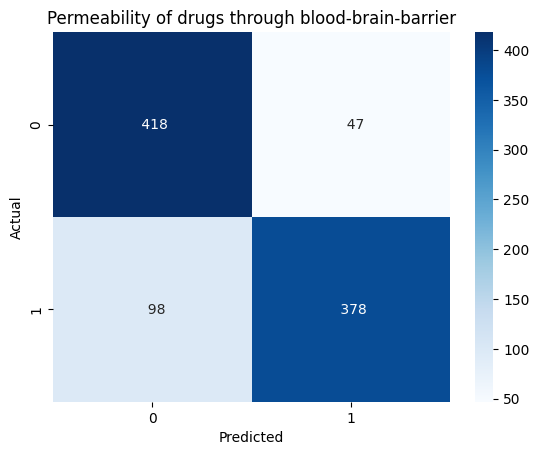

In [29]:
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, fmt='4g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Permeability of drugs through blood-brain-barrier')
plt.show()

## Pycaret pipeline for classification

In [30]:
from pycaret.classification import *

In [31]:
reduced_data = pd.DataFrame(X_res)
reduced_data['labels'] = y_res

In [32]:
reduced_data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-74.167587,-0.996756,7.954123,-10.170083,-9.089236,0.543555,12.341965,0.624062,2.688728,-1.458065,...,-7.552795,5.322787,0.619413,-8.618954,-3.480988,-0.400625,1.117439,-1.061518,-4.796038,1
1,92.225037,42.419735,4.716671,24.825651,-37.279255,-3.626776,1.437448,2.698268,2.054265,6.807059,...,1.629251,-3.775596,-8.851215,0.914740,4.299535,-13.252625,3.122720,-2.901517,-0.668159,1
2,-31.415817,-17.568005,-29.415537,4.012112,-3.580359,8.638283,-4.589925,-13.917303,-0.626637,12.066761,...,4.960220,4.564825,2.261058,-4.861485,-9.279594,1.337490,3.126763,-1.087729,-0.588485,1
3,-75.985245,3.011175,17.944036,17.009014,-8.112281,11.603303,2.847257,3.253739,7.401922,7.330302,...,-7.301838,-0.741727,-8.923892,4.528469,3.458456,-1.959076,-0.213407,2.972574,0.245770,1
4,-2.505742,1.356949,-32.659760,-3.806558,2.829599,2.198839,-8.433534,-11.375056,-4.505994,6.733484,...,-2.938817,5.512522,-2.902334,-2.648396,-1.194102,3.019176,-7.291344,5.654909,-1.800486,1


In [33]:
exp_clf101 = setup(data=reduced_data, target='labels',
                   fold_strategy='kfold', fold_shuffle=True,
                   #fix_imbalance=True, fix_imbalance_method='SMOTE',
                   normalize=True, normalize_method='robust',
                   remove_multicollinearity=True, multicollinearity_threshold=0.9,
                   experiment_name='bbbp_classifier',
                   memory=RESULTS_DIR, profile=True,
                   session_id=69763)

,Description,Value
0,Session id,69763
1,Target,labels
2,Target type,Binary
3,Original data shape,"(3134, 21)"
4,Transformed data shape,"(3134, 21)"
5,Transformed train set shape,"(2193, 21)"
6,Transformed test set shape,"(941, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


Loading profile... Please Wait!
Profiler Failed. No output to show, continue with modeling.


In [34]:
top_n = compare_models(sort='F1', n_select=2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9576,0.9880,0.9609,0.9547,0.9577,0.9150,0.9152,0.1160
rf,Random Forest Classifier,0.9462,0.9861,0.9376,0.9547,0.9459,0.8922,0.8927,0.1670
lightgbm,Light Gradient Boosting Machine,0.9362,0.9792,0.9127,0.9582,0.9346,0.8721,0.8735,0.0750
gbc,Gradient Boosting Classifier,0.9029,0.9575,0.8520,0.9502,0.8975,0.8056,0.8113,0.2290
dt,Decision Tree Classifier,0.8910,0.8913,0.8350,0.9418,0.8848,0.7819,0.7875,0.0260
knn,K Neighbors Classifier,0.8513,0.9330,0.7727,0.9190,0.8386,0.7028,0.7132,0.0920
ada,Ada Boost Classifier,0.8226,0.8959,0.7965,0.8411,0.8170,0.6451,0.6477,0.0880
qda,Quadratic Discriminant Analysis,0.8003,0.8969,0.7512,0.8341,0.7895,0.6006,0.6048,0.0210
lr,Logistic Regression,0.7765,0.8715,0.7539,0.7910,0.7708,0.5534,0.5556,0.2730
svm,SVM - Linear Kernel,0.7619,0.0000,0.7590,0.7654,0.7607,0.5241,0.5261,0.0190


### Fine tuning best model

In [35]:
best_model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9727,0.9799,0.9906,0.9545,0.9722,0.9455,0.9461
1,0.9409,0.9726,0.9643,0.9231,0.9432,0.8817,0.8826
2,0.9545,0.9870,0.9633,0.9459,0.9545,0.9091,0.9092
3,0.9726,0.9906,0.9658,0.9826,0.9741,0.9450,0.9452
4,0.9498,0.9929,0.9364,0.9626,0.9493,0.8996,0.8999
5,0.9635,0.9913,0.9737,0.9569,0.9652,0.9268,0.9269
6,0.9406,0.9844,0.9322,0.9565,0.9442,0.8808,0.8811
7,0.9452,0.9912,0.9394,0.9394,0.9394,0.8894,0.8894
8,0.9635,0.9932,0.9727,0.9554,0.9640,0.9269,0.9271


In [36]:
tuned_model = tune_model(best_model, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8818,0.9448,0.9245,0.8448,0.8829,0.7641,0.7673
1,0.8409,0.9208,0.8393,0.8468,0.8430,0.6818,0.6818
2,0.8545,0.9374,0.8807,0.8348,0.8571,0.7092,0.7103
3,0.8447,0.9354,0.7949,0.9029,0.8455,0.6908,0.6964
4,0.8584,0.9227,0.8636,0.8559,0.8597,0.7169,0.7169
5,0.8630,0.9404,0.8684,0.8684,0.8684,0.7256,0.7256
6,0.8493,0.9112,0.8051,0.9048,0.8520,0.6996,0.7045
7,0.8402,0.9322,0.8283,0.8200,0.8241,0.6777,0.6777
8,0.8904,0.9518,0.8909,0.8909,0.8909,0.7808,0.7808


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


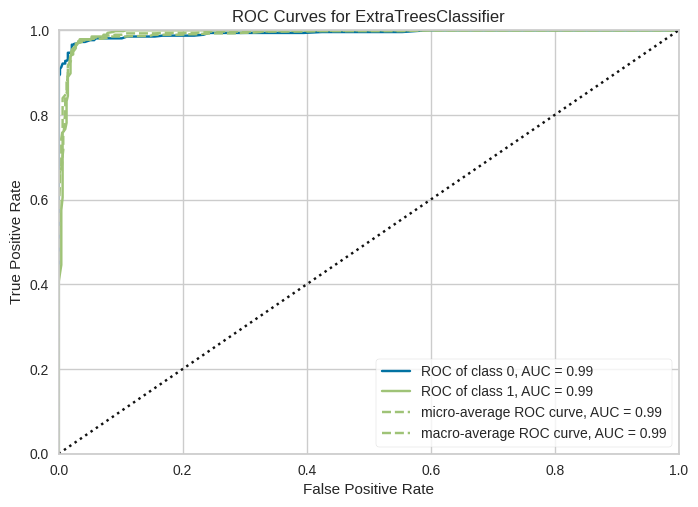

In [37]:
plot_model(tuned_model, plot = 'auc')#, save=True)

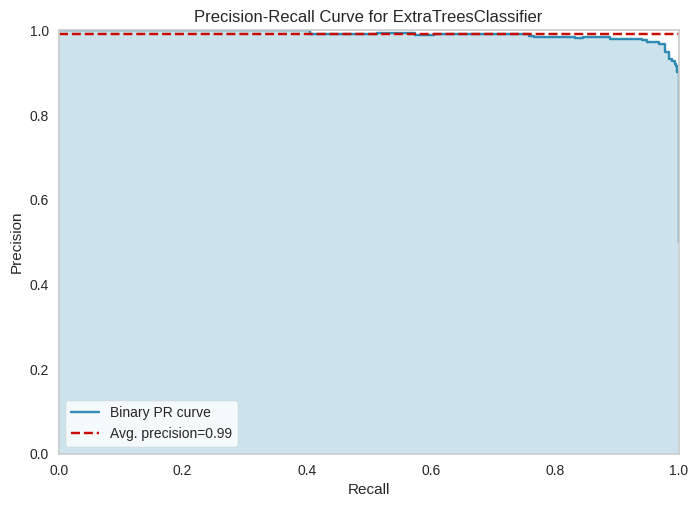

In [38]:
plot_model(tuned_model, plot = 'pr')#save=True

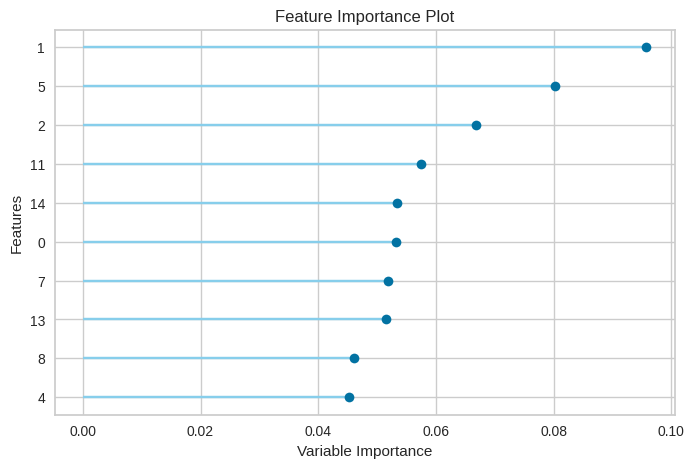

In [39]:
plot = plot_model(tuned_model, plot='feature')#save=True

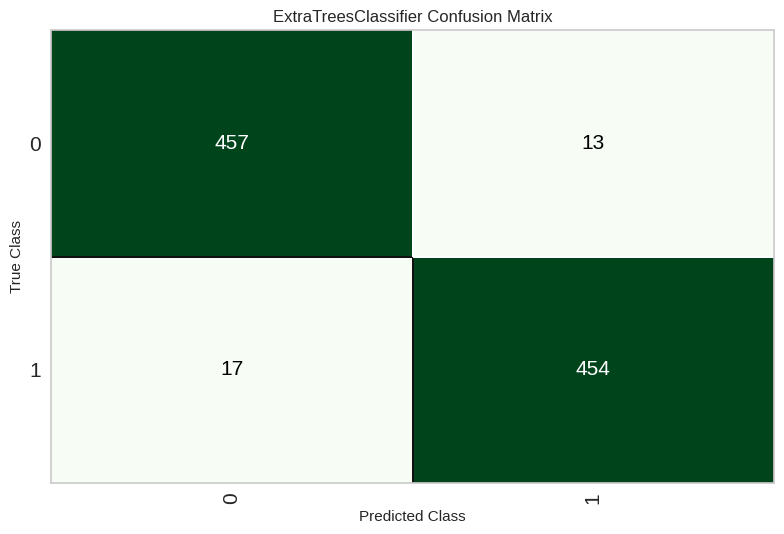

In [40]:
plot_model(tuned_model, plot = 'confusion_matrix')#save=True

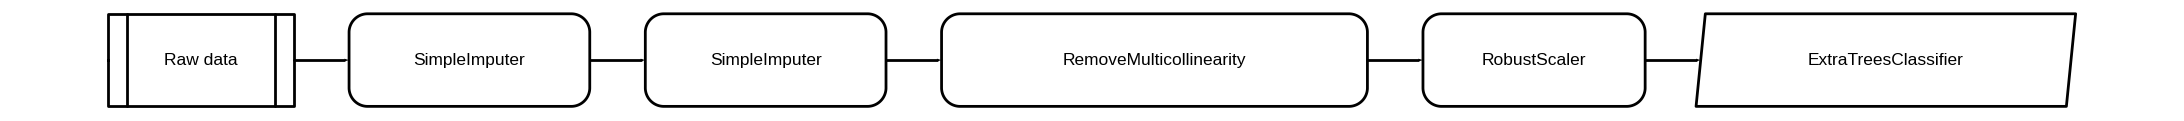

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [41]:
evaluate_model(tuned_model)

In [42]:
final_model = finalize_model(tuned_model)
print(final_model)

Pipeline(memory=FastMemory(location=/home/pranjal/git_repos/drug_discovery/drug_discovery/results/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['0', '1', '2', '3', '4', '5', '6',
                                             '7', '8', '9', '10', '11', '12',
                                             '13', '14', '15', '16', '17', '18',
                                             '19'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_f...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, ma